<a href="https://colab.research.google.com/github/marianavalho/ML2025/blob/main/Ass3_MN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pipeline for deep learning with PyTorch**

## Major steps from data to deployment

| Step                | Key Actions                                                                | Main PyTorch Classes/Methods                  |
|---------------------|----------------------------------------------------------------------------|-----------------------------------------------|
| Data Preparation    | Load, transform, batch, and split data                                     | `torch.utils.data.Dataset`, `DataLoader`, `torchvision.transforms`  |
| Model Development   | Define architecture, choose loss/optimizer, set hyperparameters            | `torch.nn.Module`, `torch.nn.Parameter`, `torch.nn.functional`, `torch.optim` |
| Model Training      | Forward pass, loss computation, backward pass, parameter update, epochs    | `forward()`, `loss.backward()`, `optimizer.step()`, `optimizer.zero_grad()` , `model.train()` |
| Validation          | Evaluate on validation set, compute metrics, tune hyperparameters          | `model.eval()`, `torch.no_grad()`, metric functions (e.g., `torchmetrics`) |
| Testing/Deployment  | Final evaluation on test set, save and deploy model                        | `torch.save()`, `torch.load()`, `model.eval()`, `torch.jit` |

## Typical training loop.

Recall that the whole set of examples is visited during one epoch. Moreover, the *dataloader* groups examples in batches, and defines some other functionalities like shuffling the examples each time the iterator is created with `for inputs, targets in dataloader` in the example below.

For standard neural network training in PyTorch, inputs and targets should be tensors. This can be dealt with in the *data preparation* step, using `transforms` when creating the custom `Dataset` class for the problem at hand (see https://github.com/isa-ulisboa/greends-pml/blob/main/notebooks/T6_pytorch_dataset_dataloader.ipynb).

As discussed in https://github.com/isa-ulisboa/greends-pml/blob/main/docs/T1_basic_concepts.md for a simple linear regression problem, PyTorch uses **backpropagation** as the strategy to updates the model weights for loss minimization. The exact same idea can be generalized to multilayer neural networks and deep-learning.

The typical training loop in PyTorch is described in the code below.
1. The forward pass is done with `model(inputs)` that applies the model to the input and computes the output. This is a probability distribution over the possible labels.
2. The backward pass is done with `optimizer.step()` using the gradient computed with `loss.backward()`. The loss, as always, depends on the actual output `target` and the predicted output `outputs`. The line of code `optimizer.zero_grad()` prevents the gradients to be summed up along the process. For  backpropagation to work, the model must be in training mode, which it is set by default or by setting `model.train()`.

  ```
  for epoch in range(num_epochs):
      for inputs, targets in dataloader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
  ```

## Example for data preparation and model training: the MNIST data set

### Step 1: Data preparation

In [ ]:
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [ ]:
# Define a transformation to flatten the 8x8 images
transform = transforms.Compose([
    transforms.Resize((8, 8)),         # Resize the PIL Image to 8x8 first (MNIST images are originally 28x28)
    transforms.ToTensor(),             # Then convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # Finally, flatten the tensor
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Question**. Dataloaders `train_loader` and `test_loader` are iterators which allow to access examples and labels.
- What is the type of objects yielded by the train and test dataloaders?

R: The train_loader and test_loader yield tuples of two PyTorch tensors: (images, labels).

- What is the *shape* of `images` returned by `for images, labels in train_loader`? How do you interpret that shape?

R: The shape is (batch_size, 64). Where "batch_size" is the mumber of samples per batch (in this case 64). And "64"  is the flattened image 8 height × 8 width = 64 pixels.
This means each batch contains 64 images, each represented as a 1D tensor of 64 pixel values.

- Why dataloaders for train and test differ with respect to the option `shuffle`?

R: During training, `shuffle=True` randomly changes the order of samples at each epoch to reduce bias, prevent overfitting, and improve generalization by exposing the model to varied data sequences.
During testing or validation, `shuffle=False` is used preserves original sample order. And to ensure consistent and repeatable evaluation results.





#### Visualize some examples and labels

Since the `transform` that was applied above returns flattened tensors, one needs to unflatten them to be able to create an image that can be plotted.

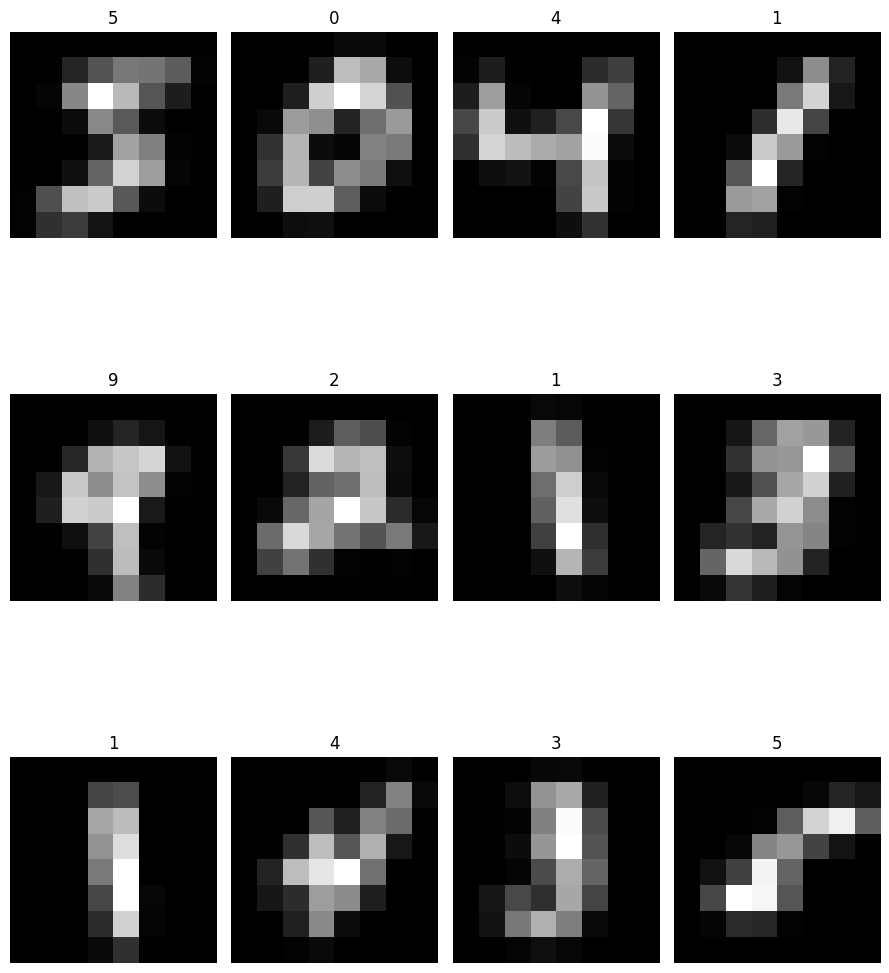

In [ ]:
# Assuming each image is a 1D tensor of length 64 (8*8)
images, labels = zip(*[train_dataset[i] for i in range(12)])

fig, axes = plt.subplots(3, 4, figsize=(9, 12))
for i, ax in enumerate(axes.flat):
    img = images[i].reshape(8, 8)  # Unflatten to 2D
    ax.imshow(img, cmap='gray')
    ax.set_title(str(labels[i]), fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Step 2: model development

In [ ]:
# Model Development: the model is a multilayer perceptron with one hidden layer
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Since we are using 8x8 MNIST and flatenning the input, the input size is 8 * 8 = 64
input_size = 8 * 8
hidden_size = 128
num_classes = 10 # 0-9 digits

model = SimpleNN(input_size, hidden_size, num_classes)

**Question**:
- The model architecture depends on the input data shape. The input images of MNIST are originally of size $28 \times 28$ but they have been resized to $8 \times 8$ pixels. Which changes do you need to do in the script to use size $16 \times 16$? And if you just want to use the original $28 \times 28$ size?


R: To use size 16x16:

transform = transforms.Compose([

    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

input_size = 16 * 16  # 256



To use size original 28x28:

transform = transforms.Compose([

    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])


input_size = 28 * 28  # 784




- Which change you need to do in the `SimpleNN` class if you want your model to have two hidden layers?



R: Add a second linear layer (fc2) and activation and update the forward pass:

class SimpleNN(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out



- What is a `ReLU` activation function?

R: The ReLU (Rectified Linear Unit) activation function outputs the input directly if it is positive; otherwise, it outputs zero. Mathematically, it’s defined as `ReLU(x) = max(0, x)`. It introduces non-linearity to the model, helping neural networks learn complex patterns and is computationally efficient.
In the code, nn.ReLU() is applied after each hidden layer to activate the outputs.


- Why are non linear activation functions like `ReLU` necessary for deep learning?

R: Nonlinear activation functions like ReLU enable deep learning by introducing essential nonlinearity. Without them, neural networks would collapse into single linear layers, unable to learn complex patterns.
It's computationally efficient and promotes sparsity by zeroing negative inputs. ReLU introduces non-linearity, allowing the network to approximate complex functions and solve tasks like image recognition or language processing effectively.



In [ ]:
# Loss and optimizer: necessary for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Some details about cross entropy, softmax, one hot encoding and distributions

Since the problem is a *classification problem*, the criterion to compare model predictions with actual labels (what was denoted be $y$ and $\hat{y}$ for regression) is typically `criterion = nn.CrossEntropyLoss()`. This function has two arguments:
1. the output of the model (a list of scores returned by the model for each possible class, where the largest score corresponds to the most likely class) and
2. the target, which is the actual label of example. For instance if there are 10 classes $0, 1, \dots, 9$, the output would be a list like $[0.3,1.2,2.5,0.2,...]$ with 10 values, and the target could be 2 for instance.

The `nn.CrossEntropyLoss()` function will internally process the scores an the target the following way.

1. **Scores**. The unormalized model outputs $f_1, \dots, f_k$ are called *scores*, *logits* or *raw* outputs. Each score $z_i=f_i({\rm \bf x};{\rm \bf w_i})$ is converted into a [0,1] value by the *softmax* function:
$$p_i=\frac{\exp(z_i)}{\sum_{j=1}^k \exp(z_j)} ~~ {\rm which~implies~that} ~~ 0<p_i \le 1.$$
After that transformation, the classification model's probabilistic output is a vector of values $(p_1,\dots,p_k)$, with $p_i \ge 0$ and $\sum p_i=1$ as required for  probability distributions. The predicted label is the one with highest $p$.

<img src="https://drive.google.com/uc?export=view&id=1iD519g8QbBmOGp9SiOQsIneJnWg53SMQ" width="600" >


2. **Target**. A target value of, say, 2 is one-hot-encoded into the list $[0,0,1,0,...,0]$ of length 10.

The **cross-entropy loss** measures the dissimilarity between the probability distribution returned by *softmax* $(p_1,p_2,\dots)$ and the one hor encoded target distribution $(t_1,t_2,\dots)$ for each example. Its value range from 0 (optimal value associated to minimum uncertainty) and 1 (maximum value associated to maximum uncertainty, i.e. all probabilities are equal):

$$L_{single~example}=-\left( t_1 \, \log(p_1) + t_2 \, \log(p_2) + \dots \right) \in [0,1].$$

In the expression above, we suppose that the probabilities $p_i$ are non zero which is guaranteed by th e*softmax* function.

For a batch of $n$ examples, the cross-entropy loss is given by the average of the $n$ individual loss values, where $L_i$ is the cross entropy for the $i$th example:

$$L_{batch}=\frac{1}{n} \left( L_1+L_2+ \dots,L_n\right).$$


### Step 3: Model training

In [ ]:
# number of epochs
num_epochs = 3

#### Typical training loop

In [ ]:
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


epoch: 1; time: 1750071404
epoch: 2; time: 1750071424
epoch: 3; time: 1750071436


#### Change device: run training on GPU

Training involves many large matrix computations. In general, this is done faster if it is parellelized over multiple cores. One can determine which device, either `cuda` (for GPU) or `cpu`, is used for training. Both model and data must be moved to the right device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device) #<<<<<<<<<< move model to device

#move data to GPU
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    for images, labels in train_loader:
        images = images.to(device)  #<<<<<<<<<< move data to device
        labels = labels.to(device)  #<<<<<<<<<< move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Using device: cpu
epoch: 1; time: 1750071447
epoch: 2; time: 1750071459
epoch: 3; time: 1750071471


**Question**. Which of the following parameters that were defined earlier about the data, model or training you expect will drive computation time down when using GPU? Why?
- image size;
- number of nodes in the hidden layer;
- loss function;
- optimizer;

R: Number of nodes in the hidden layer.

This directly increases the size of matrix operations (more neurons = more weights = more computations), so GPU parallelism speeds this up the most.




### Step 4: Validation

Validation is important for several goals, including:
- to estimate the accuracy of the model for the task at hand;
- to determine the optimal number of iterations (epochs);
- to be able to tune the model choosing the best hyperparameters.

Below, we will concentrate on the first two of those issues, and we will compare the estimated overall accuracy over the train and the test sets. In order to do this need to keep track of the intermediate results for each epoch and each batch of examples.

In [ ]:
# Model Training
num_epochs = 5

# Computes the accuracy for a batch: outputs are probability-like values
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = len(labels)
    return correct / total

# History object to keep track of accuracy along epochs
history = {'epoch': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    batch_accuracies=[]
    for images, labels in train_loader:
        images = images.to(device)  #<<<<<<<<<< move data to device
        labels = labels.to(device)  #<<<<<<<<<< move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # compute accuracy over the batch
        batch_accuracies.append(compute_accuracy(outputs, labels))
    history['epoch'].append(epoch)
    history['train_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))

    # Validation phase
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.eval()
    batch_accuracies=[]
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  #<<<<<<<<<< move data to device
            labels = labels.to(device)  #<<<<<<<<<< move data to device
            outputs = model(images)
            # compute accuracy over the batch
            batch_accuracies.append(compute_accuracy(outputs, labels))
        history['val_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))

epoch: 1; time: 1750071483
epoch: 1; time: 1750071495
epoch: 2; time: 1750071496
epoch: 2; time: 1750071509
epoch: 3; time: 1750071512
epoch: 3; time: 1750071523
epoch: 4; time: 1750071526
epoch: 4; time: 1750071538
epoch: 5; time: 1750071540
epoch: 5; time: 1750071552


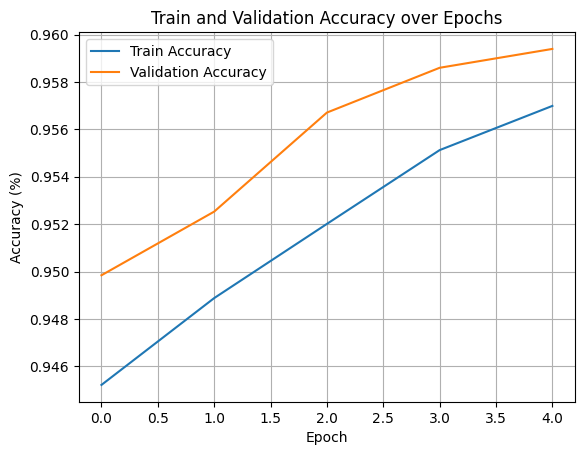

In [ ]:
# accuracy plot
plt.plot(history['epoch'], history['train_accuracy'], label='Train Accuracy')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Question**:
- From the visualization of that plot, do you think that 5 epochs are enough, or should the model train longer than that?


R: Five epochs are sufficient since accuracy is not improving significantly between the last few epochs.

- Can you find a reason for the validation curve to be consistently higher than the training curve, which in principle should not happen


R: The validation accuracy being consistently higher than training accuracy can occur due to multiple reasons.
Training/Test Set Mismatch: The test set may have simpler examples or fewer outliers.
Training Accuracy Measurement Timing: Training accuracy is logged mid-epoch (during optimization), while validation uses the fully updated model.
